# Exercise 62: From Movie Dialogue to Document Vectors

In [21]:
import pandas as pd
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords
import random
import warnings
warnings.filterwarnings("ignore")

Set the display column width to be as wide as it needs to be in order to display the
movie lines.

In [2]:
pd.set_option('display.max_colwidth', -1)

Provide the location of the movie_lines.txt file and assign that location to
the movie_lines_file variable.

In [3]:
from pathlib import Path 

movie_lines_file = Path(r'dataset\cornell-movie-dialogs\movie_lines.txt')

The columns in the movie_lines.txt file are delimited by '+++$+++'. For loading the
movie dialogue, you will need to iterate over each movie line in the file and split
the columns. After that, you need to create a DataFrame containing the movie lines.

In [4]:
with movie_lines_file.open() as f:
    movie_lines = [line.strip().split('+++$+++') for line in f.readlines()]

In [6]:
lines_df = pd.DataFrame([{'LineNumber': d[0].strip(),
                         'Person': d[3].strip(),
                         'Line': d[4].strip(),
                         'Movie': d[2].strip()}
                        for d in movie_lines])

lines_df = lines_df.set_index('LineNumber')

In [7]:
lines_df.head(10)

,Person,Line,Movie
LineNumber,,,
L1045,BIANCA,They do not!,m0
L1044,CAMERON,They do to!,m0
L985,BIANCA,I hope so.,m0
L984,CAMERON,She okay?,m0
L925,BIANCA,Let's go.,m0
L924,CAMERON,Wow,m0
L872,BIANCA,Okay -- you're gonna need to learn how to lie.,m0
L871,CAMERON,No,m0
L870,BIANCA,"I'm kidding. You know how sometimes you just become this ""persona""? And you don't know how to quit?",m0


In [9]:
len(lines_df)

304713

In [10]:
# To display the count of distinct observations in a DataFrame,
lines_df.nunique()

Person    5356  
Line      265786
Movie     617   
dtype: int64

In [11]:
lines_df_small = lines_df.head(50000)

We now create a class, the object of which will create the training instances for
the Doc2Vec model.

In [28]:
class DocumentDataset(object):
    
    def __init__(self, data:pd.DataFrame, column):
        document = data[column].apply(self.preprocess)
        self.documents = [TaggedDocument(text, [index])
                     for index, text in document.items()]
    def preprocess(self, document):
        return preprocess_string(remove_stopwords(document))
    
    def __iter__(self):
        for document in self.documents:
            yield document
    def tagged_documents(self, shuffle=False):
        if shuffle:
            random.shuffle(self.documents)
        return self.documents

In the code, the preprocess_string() function applies the given filters to the input.
The remove_stopwords() function is used to remove stopwords from the given
document.
Doc2Vec requires each instance to be a TaggedDocument instance. So, internally, we
create a list of TaggedDocument for each movie line in the file.

Now create an object of the DocumentDataset class. It takes two parameters. One is
the lines_df_small DataFrame and another one the "Line" column name.

In [30]:
documents_dataset = DocumentDataset(lines_df_small, 'Line')

In [31]:
# Now we create a Doc2Vec model using the Doc2Vec class.
docVecModel = Doc2Vec(min_count=1, window=5, vector_size=100, sample=1e-4,negative=5, workers=8)

docVecModel.build_vocab(documents_dataset.tagged_documents())

In the code, the Doc2Vec class contains parameters such as min_count, window,
vector_size, sample, negative, and workers. The min_count parameter ignores all
the words with a frequency less than that specified. The window parameter sets the
maximum distance between the current and predicted word in the given sentence.
The vector_size parameter helps in setting the dimensions of each vector. sample
is the threshold that allows us to configure the higher-frequency words that are
regularly downsampled. negative specifies the total amount of noise words that
should be drawn. workers specifies the total number of threads required to train
the model.

Now we need to train the model using the train() function of the Doc2Vec class.
This could take a while, depending on how many records we train. Here epochs
states the total number of it required to train the document.

In [32]:
docVecModel.train(documents_dataset.tagged_documents(shuffle=True),
                 total_examples=docVecModel.corpus_count,
                 epochs=10)

In [44]:
# The model has been trained. In order to check that, we need to access one of the vectors.
docVecModel['L872']

array([ 2.00740481e-03, -2.56481394e-03,  1.07402785e-03,  4.12506610e-03,
       -6.52146013e-03,  5.65765519e-03, -1.51522434e-03,  1.36431982e-03,
        2.42220284e-03, -9.67851782e-04, -9.41455271e-03, -4.86226706e-03,
        6.74681971e-03, -6.54865848e-03,  3.06608644e-03,  3.73357558e-03,
       -5.71757881e-03,  5.34214173e-03, -1.76930765e-03, -2.64442380e-04,
        6.49584970e-03,  6.57471828e-03, -8.79454147e-03,  1.11976842e-04,
       -2.32730163e-05, -5.26313728e-04,  3.68390768e-03, -2.23210151e-03,
       -3.99507023e-03, -8.93792079e-04, -6.83911797e-03,  8.13798606e-03,
       -7.50814471e-03,  1.76514720e-03, -5.40891197e-03, -1.38192589e-03,
        3.95007257e-04, -4.16365778e-03,  6.88218093e-03, -6.30038371e-03,
       -1.44563755e-03,  8.99838167e-04, -1.52748749e-02, -9.91841312e-04,
        6.97445648e-04,  3.02610715e-04,  1.18979253e-03, -5.46956807e-03,
       -7.38804927e-03, -9.88892745e-03, -1.13594895e-02,  7.64420768e-03,
        4.82969405e-03, -

To check the image representation of any given vector, we make use of the pyplot
framework of the Matplotlib library. The show_movie_line() function takes a line
number as a parameter. Based on this line number, we find the vector and store it
in the doc_vector variable. The show_image() function takes two parameters, vector
and line, and displays the image representation of the vector.

In [34]:
import matplotlib.pyplot as plt

In [35]:
def show_image(vector, line):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    ax.tick_params(axis='both',
                  which='both',
                  left=False,
                  bottom=False,
                  top=False,
                  labelleft=False,
                  labelbottom=False)
    
    ax.grid(False)
    print(line)
    ax.bar(range(len(vector)), vector, 0.5)


In [42]:
def show_movie_line(line_number):
    line = lines_df_small.loc['L872'].Line
    doc_vector = docVecModel[line_number]
    show_image(doc_vector, line)

Since we have defined our functions now, let's implement the show_movie_line()
function to view the image representation of the vector.

Okay -- you're gonna need to learn how to lie.


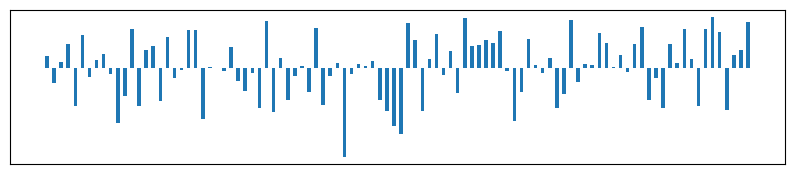

In [43]:
show_movie_line('L872')